# Simple RBC Model in Discrete Time

In [1]:
# Load packages
using Printf, Random, Distributions, NLsolve, Plots, PyPlot, LinearAlgebra, Arpack

In [2]:
# Settings
# Parameters of AR(1) log technology process
par = Dict()
par["omega"] = 0;
par["rho"]   = 0.6;
par["sigma"] = 0.023;

# Agent's problem parameters
par["theta"] = 2;
par["beta"]  = 0.96;
par["alpha"] = 0.34;
par["delta"] = 0.1;

# Special parameters
par["x_n_grid"] = 51;  # grid size for log TFP
par["k_n_grid"] = 100; # grid size for capital
par["cons_bound"] = 1e-2; # consumption bound
par["tol"] = 1e-6; # tolerance value for VFI

In [3]:
function sigmoid(x)
    return 1.0 ./ (1.0 .+ exp.(-x))
end;

# Discretize AR(1) processes

We start with the following standard AR(1) process:
$$
x_{t} = \omega + \rho x_{t-1} + \sigma \varepsilon_t
$$
where $\varepsilon_t \sim \mathcal{N}(0, 1)$. 

We want to make a Markov-Switching discrete approximation for the following possible realizations: $x = (x_1, ..., x_N)$:


$$
P(x^{(t+1)} = x_1 | x^{(t)} = x_r ) = F\left(\frac{x_1 + 0.5 \Delta x - \omega - \rho x_r}{\sigma}\right)
$$

$$
P(x^{(t+1)} = x_s | x^{(t)} = x_r ) = F\left(\frac{x_s + 0.5 \Delta x - \omega - \rho x_r}{\sigma}\right) -
 F\left(\frac{x_s - 0.5 \Delta x - \omega - \rho x_r}{\sigma}\right)
$$

$$
P(x^{(t+1)} = x_N | x^{(t)} = x_r ) = 1 - F\left(\frac{x_N - 0.5 \Delta x - \omega - \rho x_r}{\sigma}\right)
$$

This process can be represented in the following way:
$$
x_t = \omega \frac{1 - \rho^t}{1 - \rho} + \rho^t x_0 + \sigma \sum_{j = 1}^{t} \rho^{t-j} \varepsilon_{j}
$$

<!-- Marginal distribution then:
\begin{equation}
x_{\infty} \sim \mathcal{N}\left( \frac{\omega}{1 - \rho} , \frac{\sigma^2}{1 - \rho^2} \right)
\end{equation}
Discretized marginal distribution can be derived using transition matrix:
\begin{equation}
P^{\star} = M^{\infty} P_0
\end{equation} -->

In [4]:
# Functions declaration
function construct_x_grid(p)
    p["x_mu"]     = p["omega"]
    p["x_sigma"]  = p["sigma"]/sqrt((1 - p["rho"]^2))
    p["x_bounds"] = p["x_mu"] .+ 4.5*p["x_sigma"]*[-1, 1]
    p["x_delta"]  = (p["x_bounds"][2] - p["x_bounds"][1])/(p["x_n_grid"] - 1)
    x_grid = LinRange(p["x_bounds"][1], p["x_bounds"][2], p["x_n_grid"])
    
    return p, x_grid
end;

function discretize_AR1(p, x_grid)
    d = Normal(0, 1)
    M = zeros(p["x_n_grid"], p["x_n_grid"])
    
    M_prev = repeat(x_grid, 1, p["x_n_grid"]-2)
    M_cur  = repeat(x_grid[2:end-1]', p["x_n_grid"], 1)

    M[:, 1]  = cdf.(d, (x_grid[1] .+ 0.5 .* p["x_delta"] .- 
            p["omega"] .- p["rho"] .* x_grid) ./ p["sigma"]);
    M[:, 2:end-1] = cdf.(d, (M_cur .+ 0.5 .* p["x_delta"] .+ 
            p["omega"] .- p["rho"] .* M_prev) ./ p["sigma"]) -
            cdf.(d, (M_cur .- 0.5 .* p["x_delta"] .+ 
            p["omega"] .- p["rho"] .* M_prev) ./ p["sigma"]);
    M[:, end] = 1 .- cdf.(d, (x_grid[end] .- 0.5 .* p["x_delta"] .- 
            p["omega"] .- p["rho"] .* x_grid) ./ p["sigma"]);
    return M 
end;

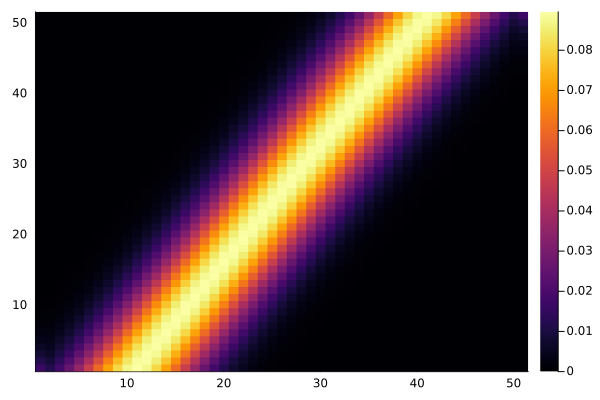

In [5]:
par, x_grid = construct_x_grid(par);
M = discretize_AR1(par, x_grid);

heatmap(M)

# Value function iterations
## Steady state
Steady state implies that $c_t = c_{t+1} = c_{ss}$, $k_t = k_{t+1} = k_{ss}$ and $log(x_t) = \mathbb{E} x$ (determined, without any oscillation). Hence:
\begin{align}
u'(c_{t}) = \beta \left( \alpha \times  exp\left(\mathbb{E} x \right) k_{ss}^{\alpha-1} + (1 - \delta) \right) u'(c_{t+1}) \\
1 = \beta \left( \alpha \times  exp\left(\mathbb{E} x \right) k_{ss}^{\alpha-1} + (1 - \delta) \right) \\
k_{ss} = \left( \frac{\alpha \times exp\left(\mathbb{E} x \right) }{\frac{1}{\beta} - (1-\delta)}  \right)^{\frac{1}{1 - \alpha}}
\end{align}

## Restricting grid for possible capital values
We want to avoid equillibria with consumption approaching $0$. Therefore, we want to restrict all possible capital values to get nonzero consumption. Zero consumption could be solution, if an agent chooses today the lowest possible consumption to invest in the highest possible capital in the future. Hence, we want:

$$
c_{low} = exp(x_{low}) \left( k_{lower} \right)^{\alpha} + (1-\delta) (k_{lower}) - k_{upper} >> 0
$$

Assume a symmetric grid around the steady state: $k_{lower} = (1-ab)k_{ss}$ ; $k_{lower} = (1+ab)k_{ss}$. Therefore,

$$
c_{low} = exp(x_{low}) \left( (1 - ab) k_{ss} \right)^{\alpha} + (1-\delta)( (1 - ab) k_{ss}) - (1 + ab) k_{ss}= const>> 0
$$

## Problem
In discretized form we want to solve the following problem:
$$
V(k, x_r) = u\left( f(k, x_r) + (1 - \delta)k - k'  \right) + \beta \sum_{j=1}^{J} V(k', x_j) P(x^{(t+1)} = x_j | x^{(t)} = x_r ) \rightarrow max_{k' \in [k_{lower}, k_{upper}]}
$$


In [6]:
function VFI_simple_rbc(p, x_grid, M)
    # Define lambda functions
    u = c -> (c.^(1 .- p["theta"]) .- 1) ./ (1 .- p["theta"]);
    prod_fun = (k, x) -> (k.^p["alpha"])*exp(x)

    # Steady state
    k_ss = (p["alpha"]*exp(par["x_mu"])/(1/par["beta"] - (1 - p["delta"]) ))^(1/(1 - p["alpha"]))

    # Choose lower bound for k
    function f!(F, x)
        F[1] = (exp(x_grid[1])*((1-sigmoid(x[1]))*k_ss)^p["alpha"]) +
        (1 - p["delta"])*((1-sigmoid(x[1]))*k_ss) .- (1+sigmoid(x[1]))*k_ss .- p["cons_bound"]
    end
    res_nlsolve = nlsolve(f!, [0.0], autodiff = :forward)
    ab_opt = sigmoid(res_nlsolve.zero)[1]

    # Create grid for capital
    k_grid = LinRange( (1 - ab_opt)*k_ss, (1 + ab_opt)*k_ss,  p["k_n_grid"])
    @printf("Capital bounds: k in [%.2f, %.2f]; k_ss = %.2f; ab_opt = %.4f \n", k_grid[1], k_grid[end], k_ss, ab_opt)
    
    # Initialize VFI
    V = zeros(p["k_n_grid"], p["x_n_grid"])
    V_next = zeros(p["k_n_grid"], p["x_n_grid"])
    k_next_opt = zeros(p["k_n_grid"], p["x_n_grid"])

    # Capital structures
    k_cur = repeat(k_grid', p["k_n_grid"], 1)
    k_next = k_cur'
    k_grid_mat = k_next

    dist = p["tol"] + 10
    ii = 1
    println("VFI starts")
    @time begin
    while dist > p["tol"]
        for i in 1:p["x_n_grid"]
            V_tmp = u(prod_fun(k_cur, x_grid[i]) + (1 - p["delta"]).*k_cur - k_next) +
            repeat(p["beta"].* V * M[[i], :]', 1, p["k_n_grid"])

            idx = argmax(V_tmp, dims=1)
            k_next_opt[:, i] = k_grid_mat[idx]
            V_next[:, i] = V_tmp[idx]
        end
        dist = sum(broadcast(abs, V - V_next))
        V = copy(V_next)
        if mod(ii, 100) == 0
    @printf("iter: %.i; dist: %.7f\n", ii, dist )
        end
        ii += 1
    end
    println("Done! dist: $dist")
    end
    
    return k_grid, k_next_opt, V_next, ab_opt
end

VFI_simple_rbc (generic function with 1 method)

In [7]:
(k_grid, k_next_opt, V_next, ab_opt) = VFI_simple_rbc(par, x_grid, M);

Capital bounds: k in [3.28, 4.26]; k_ss = 3.77; ab_opt = 0.1298 
VFI starts
iter: 100; dist: 13.2982860
iter: 200; dist: 0.2243463
iter: 300; dist: 0.0037848
iter: 400; dist: 0.0000639
iter: 500; dist: 0.0000011
Done! dist: 9.927304751577992e-7
 18.125381 seconds (3.47 M allocations: 16.590 GiB, 7.09% gc time, 5.06% compilation time)


In [ ]:
pyplot()
Plots.plot(x_grid, k_grid, V_next, st=:surface, camera=(-30,30), xlabel = "x", ylabel = "k", zlabel = "V")

In [ ]:
Plots.plot(x_grid, k_grid, k_next_opt, st=:surface, camera=(-30,30), xlabel = "x", ylabel = "k", zlabel = "k'")

# Joint Distribution


In [ ]:
Pi_joint = zeros(par["k_n_grid"]*par["x_n_grid"], par["k_n_grid"]*par["x_n_grid"])

for i in 1:par["x_n_grid"]
    for j in 1:par["x_n_grid"]
        Pi_joint[(i-1)*par["k_n_grid"]+1:i*par["k_n_grid"],  (j-1)*par["k_n_grid"]+1:j*par["k_n_grid"]] = 
                M[i, j] .* (repeat(k_next_opt[:, i], 1, par["k_n_grid"]) .== repeat(k_grid, 1, par["k_n_grid"])')
    end
end


In [ ]:
res_eigen = eigs(Pi_joint', nev =1,  which=:LR);
f_joint = real.(res_eigen[2]);

f_joint = f_joint/sum(f_joint);
f_joint_mat = reshape(f_joint, (par["k_n_grid"], par["x_n_grid"]));
f_k = sum(f_joint_mat, dims = 2);

In [ ]:
Plots.plot(k_grid, x_grid, f_joint_mat', st=:surface, camera=(-30,30), xlabel = "x", ylabel = "k", zlabel = "f(k, x)")

In [ ]:
Plots.plot(k_grid, f_k[:, 1],xlabel = "k", ylabel = "p(k)")